In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
#data_folder = Path("C:/Users/merri/OneDrive/Nan's NW/Capstone")

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


# import Natural Language Tookit
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import re

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as k
from tensorflow.keras.metrics import AUC

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import mean_squared_error as MSE

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from sklearn.feature_extraction.text import CountVectorizer

from packaging import version
from tensorflow.python.client import device_lib

# for BERT tokenization
# from transformers import BertTokenizer, TFAutoModel

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# for Glove tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

# SMOTE oversampling
from imblearn.over_sampling import SMOTE

import joblib



In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

device_lib.list_local_devices()

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.10.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16664132714744209123
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22385000448
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5935548817633607078
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9"
 xla_global_id: 416903419]

In [4]:



# Download the stopwords and punkt tokenizer models
nltk.download('stopwords')
nltk.download('punkt')

# Function to determine the type of product number
def determine_number_type(s):
    if '.' in s:
        return 'float'
    elif '-' in s:
        return 'hyphenated'
    elif s.isdigit():  # checks if the string contains only numbers
        return 'numeric'
    else:
        return 'alphanumeric'

stop_words = set(stopwords.words('english'))

# Create a function to tokenize the Product_Description column based on the specified requirements:
# Convert underscores _ to spaces.
# Tokenize using spaces, commas, and other special characters.
# Filter out stopwords.
def combined_tokenizer(description):
    # Convert underscores to spaces
    description = description.replace("_", " ")

    # Tokenize based on spaces, commas, and other delimiters
    tokens = re.split(r'[ ,;()\n]+', description)

    # Tokenize further using alphanumeric boundaries
    refined_tokens = []
    for token in tokens:
        refined_tokens.extend(re.findall(r'\d+|\D+', token))
    
    # Filter out stopwords
    refined_tokens = [word for word in refined_tokens if word.lower() not in stop_words and len(word) > 1]

    return refined_tokens

# Assuming digits in Product_Description are refering to size/dimension of a product
# and may not play a significant role in classification.
# Remove digits and mean from a list of tokens and .

def remove_digits(tokens_list):
    return [token for token in tokens_list if not token.isdigit()]

def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\reedb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\reedb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# Import dataset
df=pd.read_csv('../Dataset/Commodity_Item_Master.csv')

# Delete the last two columns
df1 = df.drop(df.columns[-1:], axis = 1)

# Rename columns
columns = df1.columns.to_list() # NOTE: Commodity_Item_Master.csv has 'ï»¿Product #' column with non-alphanumeric characters; will rename to 'Product ID'
rename_dict = {
    columns[0]:'Product ID',
    columns[2]:'UNSPSC CODES',
    columns[3]:'UNSPSC Code Description'
}
df2 = df1.rename(columns = rename_dict)


# Delete rows with missing values
df3 = df2.dropna()

# Convert'UNSPSC CODES' from float to int
df3['UNSPSC CODES']=df3['UNSPSC CODES'].astype(int)

# Looks like row 294 has false UNSPSC Codes and UNSPSC Code Description, delete row 294
df4 = df3.drop(294)

# keep one row from the set of duplicated rows
df5 = df4.drop_duplicates(subset='Product ID', keep='first')

df5['ProductID_Type'] = df5['Product ID'].apply(determine_number_type)

### DESCRIPTIONS and Product ID
# Convert to lowercase for consistency
df5['DESCRIPTIONS']=df5['DESCRIPTIONS'].str.lower()
df5['Product ID']=df5['Product ID'].str.lower()

# Remove periods
df5['DESCRIPTIONS'] = df5['DESCRIPTIONS'].str.replace('.', '')
# ***** NOTE - PLEASE REVIEW: Do we need to remove periods to Product ID as well? *****
# df5['Product ID'] = df5['Product ID'].str.replace('.', '')

# Apply the function to the DESCRIPTIONS column
df5['TOKENS'] = df5['DESCRIPTIONS'].apply(combined_tokenizer)

# combine 'Product ID' and 'DESCRIPTIONS' columns into one column
df5['Product_Description'] = df5[['Product ID', 'DESCRIPTIONS']].apply(lambda x: ','.join(x), axis=1)

# Delete the row with '_na' as DESCRIPTIONS
df6 = df5[df5['DESCRIPTIONS']!='_na']


# Apply the function to the TOKENS column
df6['TOKENS'] = df6['TOKENS'].apply(remove_digits)

### UNSPSC Code Description
#### UNSPSC CODES_Segment Level
# Check how many types of Segments, which is the first level, in the UNSPSC CODES
# Convert UNSPSC CODES to string and extract the first two digits
df6['Segment'] = df6['UNSPSC CODES'].astype(str).str[:2]
df6['Family'] = df6['UNSPSC CODES'].astype(str).str[:4]
df6['Class'] = df6['UNSPSC CODES'].astype(str).str[:6]
df6['Commodity'] = df6['UNSPSC CODES'].astype(str).str[:8]

# Delete the only one entry that uses 811115035.
df6 = df6[df6['UNSPSC CODES'] != '811115035']

# Remove the string 'mm' from a list of tokens
df6['TOKENS'] = df6['TOKENS'].apply(lambda tokens: [token for token in tokens if token != 'mm'])


In [6]:
df6

,Product ID,DESCRIPTIONS,UNSPSC CODES,UNSPSC Code Description,ProductID_Type,TOKENS,Product_Description,Segment,Family,Class,Commodity
0,0,set up sheet for ccx600 d,55101516,Operation or instruction manuals,numeric,"[set, sheet, ccx]","0,set up sheet for ccx600 d",55,5510,551015,55101516
1,1000.004,"res, 270 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.004,res, 270 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706
2,1000.005,"res, 200 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.005,res, 200 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706
3,1000.06,"res, 56k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.06,res, 56k, cf, 1/8 w, 5%",32,3212,321217,32121706
4,1000.075,"res, 100k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.075,res, 100k, cf, 1/8 w, 5%",32,3212,321217,32121706
...,...,...,...,...,...,...,...,...,...,...,...
25167,z462358-14f,"36k,5%,1/16w,0402,lf",32121706,Resistor or capacito,hyphenated,[lf],"z462358-14f,36k,5%,1/16w,0402,lf",32,3212,321217,32121706
25168,z462358-42f,"res,1/16w,510k ohms,5%,0402",32121706,Resistor or capacito,hyphenated,"[res, ohms]","z462358-42f,res,1/16w,510k ohms,5%,0402",32,3212,321217,32121706
25169,z468610-04f,"c0g,15pf±025pf,50v,0201,lf",32121706,Resistor or capacito,hyphenated,"[pf±, pf, lf]","z468610-04f,c0g,15pf±025pf,50v,0201,lf",32,3212,321217,32121706
25170,z480086-01f,"side,actuated,16n,smd",39122221,Switch part or acces,hyphenated,"[side, actuated, smd]","z480086-01f,side,actuated,16n,smd",39,3912,391222,39122221


In [7]:
unique_codes = df6['Commodity'].nunique()
print("Number of unique UNSPSC CODES:", unique_codes)


Number of unique UNSPSC CODES: 197


<Axes: ylabel='Commodity'>

19720

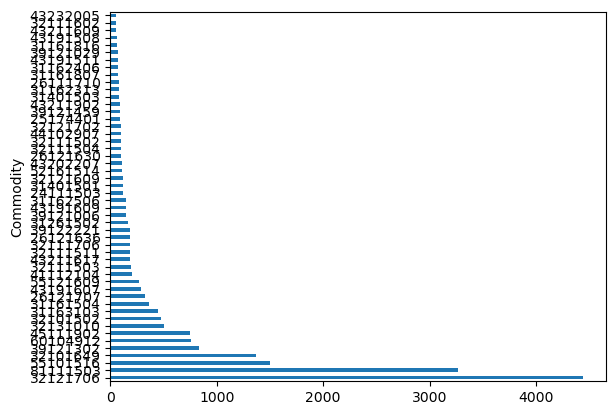

In [8]:
# get a dataframe of the top 50 Commodity CODES
y_top_50 = df6['Commodity'].value_counts().head(50)
df7 = df6[df6['Commodity'].isin(y_top_50.index.tolist())]
df7['Commodity'].value_counts().plot(kind='barh')

len(df7)

In [9]:
# Use label encoder to encode the Family CODES
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df7['Commodity'])
# y_decoded = label_encoder.inverse_transform(y_encoded)

# Use one hot encoder to encode the Family CODES
one_hot_encoder = OneHotEncoder(sparse=False)
y_one_hot_encoded = one_hot_encoder.fit_transform(df7[['Commodity']])
# y_one_hot_decoded = one_hot_encoder.inverse_transform(y_one_hot_encoded)


In [10]:
# Load the tfidf vectorizer
tfidf_vectorizer = joblib.load('tfidf_vectorizer_final.pkl')

X = tfidf_vectorizer.fit_transform(df7['Product_Description'])
X.shape


(19720, 24064)

In [11]:
tfidf_vectors = tfidf_vectorizer.inverse_transform(X)
df7['TF-IDF'] = list(tfidf_vectors)
df7 


,Product ID,DESCRIPTIONS,UNSPSC CODES,UNSPSC Code Description,ProductID_Type,TOKENS,Product_Description,Segment,Family,Class,Commodity,TF-IDF
0,0,set up sheet for ccx600 d,55101516,Operation or instruction manuals,numeric,"[set, sheet, ccx]","0,set up sheet for ccx600 d",55,5510,551015,55101516,"[ccx600, for, sheet, up, set]"
1,1000.004,"res, 270 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.004,res, 270 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706,"[cf, ohm, 270, res, 004, 1000]"
2,1000.005,"res, 200 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.005,res, 200 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706,"[200, 005, cf, ohm, res, 1000]"
3,1000.06,"res, 56k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.06,res, 56k, cf, 1/8 w, 5%",32,3212,321217,32121706,"[56k, 06, cf, res, 1000]"
4,1000.075,"res, 100k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.075,res, 100k, cf, 1/8 w, 5%",32,3212,321217,32121706,"[100k, 075, cf, res, 1000]"
...,...,...,...,...,...,...,...,...,...,...,...,...
25167,z462358-14f,"36k,5%,1/16w,0402,lf",32121706,Resistor or capacito,hyphenated,[lf],"z462358-14f,36k,5%,1/16w,0402,lf",32,3212,321217,32121706,"[14f, z462358, 36k, 0402, 16w, lf]"
25168,z462358-42f,"res,1/16w,510k ohms,5%,0402",32121706,Resistor or capacito,hyphenated,"[res, ohms]","z462358-42f,res,1/16w,510k ohms,5%,0402",32,3212,321217,32121706,"[42f, z462358, 510k, ohms, 0402, 16w, res]"
25169,z468610-04f,"c0g,15pf±025pf,50v,0201,lf",32121706,Resistor or capacito,hyphenated,"[pf±, pf, lf]","z468610-04f,c0g,15pf±025pf,50v,0201,lf",32,3212,321217,32121706,"[04f, z468610, 025pf, c0g, 15pf, 0201, lf, 50v]"
25170,z480086-01f,"side,actuated,16n,smd",39122221,Switch part or acces,hyphenated,"[side, actuated, smd]","z480086-01f,side,actuated,16n,smd",39,3912,391222,39122221,"[actuated, z480086, 01f, 16n, side, smd]"


In [12]:
# create training, validation, and testing sets
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X, y_encoded, test_size=0.1, random_state=42)
X_train_enc, X_val_enc, y_train_enc, y_val_enc = train_test_split(X_train_enc, y_train_enc, test_size=0.1, random_state=42)

In [13]:
y_test_decoded_enc = label_encoder.inverse_transform(y_test_enc)

In [14]:
# create the SMOTE object
smote = SMOTE()

# fit and apply SMOTE to the training data
X_train_smote_enc, y_train_smote_enc = smote.fit_resample(X_train_enc, y_train_enc)

# print the shape of the new training data
print('Shape of X_train_count_smote:', X_train_smote_enc.shape)
print('Shape of y_train_smote:', y_train_smote_enc.shape)


Shape of X_train_count_smote: (181950, 24064)
Shape of y_train_smote: (181950,)


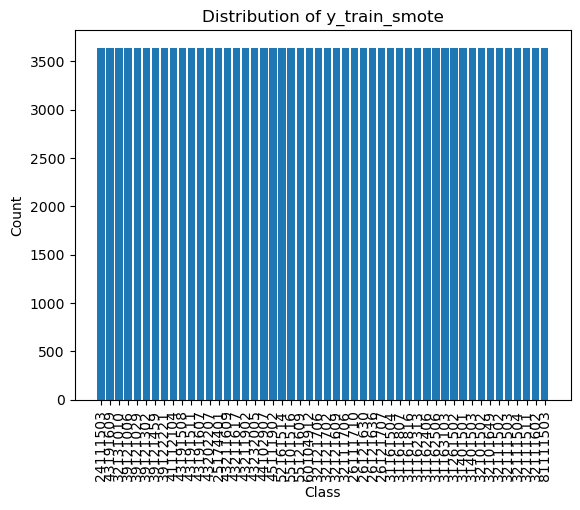

In [15]:
# create a dataframe of the class counts
class_counts = pd.DataFrame(label_encoder.inverse_transform(y_train_smote_enc), columns=['class']).value_counts().reset_index(name='count')

# plot the class counts as a bar chart
plt.bar(class_counts['class'], class_counts['count'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of y_train_smote')
plt.xticks(rotation=90)
plt.show();


In [16]:
# Load the saved model
logreg_best_model = joblib.load('logreg_best_model.pkl')

In [17]:
# Get the hyperparameters of the model
hyperparameters_logreg = logreg_best_model.get_params()

# Print the hyperparameters
hyperparameters_logreg

{'C': 100,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Logistic Regression Hyperparameter:

C: float, 100

Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

NOTE: Should we depend on a high C value for regularization? Could it lead to extreme overfitting...?

In [18]:
# Use the loaded model to make predictions on new data
pred_logreg = logreg_best_model.predict(X_test_enc)
pred_logreg_decoded = label_encoder.inverse_transform(pred_logreg)
print_validation_report(y_test_decoded_enc, pred_logreg_decoded)


Classification Report
              precision    recall  f1-score   support

    24111503       0.92      1.00      0.96        11
    25174401       1.00      1.00      1.00         6
    26111710       1.00      1.00      1.00         5
    26121630       0.78      0.70      0.74        10
    26121636       1.00      0.93      0.96        14
    26121707       0.87      0.96      0.92        28
    31161504       1.00      1.00      1.00        53
    31161807       1.00      0.83      0.91        12
    31161816       1.00      0.89      0.94         9
    31162313       0.83      0.83      0.83         6
    31162406       1.00      0.90      0.95        10
    31162506       1.00      1.00      1.00        14
    31163103       0.98      0.98      0.98        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       1.00      0.88      0.93         8
    32101502       0.86      0.98      0.92        50
    3

In [19]:
import pandas as pd

# Set the display options to show all rows
pd.set_option('display.max_rows', 200)

# Display the value counts of the 'Commodity' column
df6['Commodity'].value_counts()



Commodity
32121706    4438
81111503    3267
55101516    1502
32101649    1372
39121302     831
60104912     762
45111902     750
32131010     505
32101502     476
31163103     447
31161504     361
26121707     324
43191607     293
55121609     269
41112104     207
32111503     194
43211617     189
32111511     188
32111706     186
26121636     183
39122221     181
31261502     168
39121006     152
43191609     151
31162506     147
31401501     122
24111503     122
32121609     121
52161514     114
43202207     107
26121630     103
32111504     102
44102907     100
32111502     100
32121702      99
25174401      94
39121459      92
43211902      87
31162313      80
31401503      80
26111710      78
31162406      75
31161807      75
43191511      74
39121029      71
31161816      61
43191508      59
43211609      56
32111602      54
43232005      51
39121421      49
39121522      47
46182507      45
52161520      45
43211614      44
32131001      44
32101620      44
31201622      43
3116

In [20]:

unique_commodities = df6['Commodity'].nunique()
print("Number of unique commodities:", unique_commodities)



Number of unique commodities: 197


In [21]:
commodity_counts = df6['Commodity'].value_counts()
values_7_or_less = commodity_counts[commodity_counts <= 7].index.tolist()
values_7_or_less
len(values_7_or_less)

['31161507',
 '44122109',
 '43202001',
 '39122326',
 '56101519',
 '31161505',
 '47131502',
 '41111930',
 '32101630',
 '43211501',
 '32111611',
 '24121509',
 '43201402',
 '45121620',
 '43211515',
 '31162702',
 '43201403',
 '43201619',
 '24141709',
 '45121518',
 '31161501',
 '31161516',
 '45111501',
 '31171607',
 '41111629',
 '43202005',
 '43202222',
 '27111701',
 '31201505',
 '43191605',
 '31161725',
 '56121902',
 '43202103',
 '40101601',
 '31161520',
 '27112402',
 '45121506',
 '43223108',
 '31251516',
 '32101601',
 '31201517',
 '39121435',
 '43233404',
 '26111720',
 '40142005',
 '26121539',
 '24121507',
 '43212002',
 '23153130',
 '31161801',
 '31161740',
 '31162419',
 '31161510',
 '31161517',
 '15121902',
 '55121606',
 '31161818',
 '14111537',
 '41111916',
 '26101112',
 '43201556',
 '31161727',
 '60104906',
 '26121524',
 '26111706',
 '31161824',
 '31171507',
 '31171509',
 '43222612',
 '43211612',
 '32121708',
 '31161811',
 '43211607',
 '31201623',
 '24141516',
 '31251511',
 '46181541',

78

In [22]:
min_commodity = 20
unique_commodities = df6['Commodity'].nunique()
commodities_less_than_min_commodity = df6['Commodity'].value_counts()[df6['Commodity'].value_counts() < min_commodity].index
commodities_with_min_commodity = unique_commodities - len(commodities_less_than_min_commodity)
print("commodities_with_min_commodity:")
commodities_with_min_commodity
print("commodities_less_than_min_commodity:")
len(commodities_less_than_min_commodity)

commodities_with_min_commodity:


83

commodities_less_than_min_commodity:


114

<Axes: ylabel='Commodity'>

20768

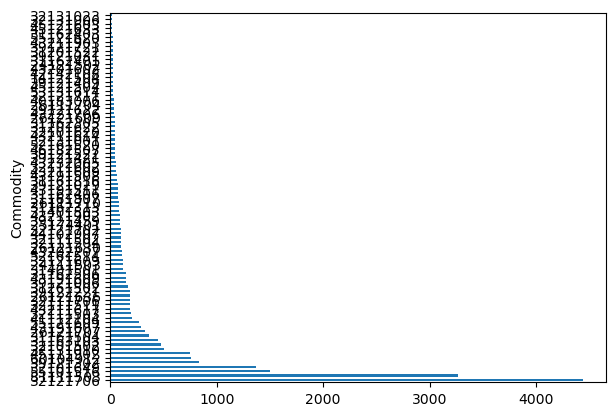

In [23]:
# get a dataframe of the top 133 83 CODES?
y_min_commodity = df6['Commodity'].value_counts().head(commodities_with_min_commodity)
# y_min_commodity = df6['Commodity'].value_counts().head(50)
df8 = df6[df6['Commodity'].isin(y_min_commodity.index.tolist())]
df8['Commodity'].value_counts().plot(kind='barh')

len(df8)

In [24]:
df8_value_counts = df8['Commodity'].value_counts()
len(df8_value_counts)
df8_value_counts

83

Commodity
32121706    4438
81111503    3267
55101516    1502
32101649    1372
39121302     831
60104912     762
45111902     750
32131010     505
32101502     476
31163103     447
31161504     361
26121707     324
43191607     293
55121609     269
41112104     207
32111503     194
43211617     189
32111511     188
32111706     186
26121636     183
39122221     181
31261502     168
39121006     152
43191609     151
31162506     147
31401501     122
24111503     122
32121609     121
52161514     114
43202207     107
26121630     103
32111504     102
32111502     100
44102907     100
32121702      99
25174401      94
39121459      92
43211902      87
31401503      80
31162313      80
26111710      78
31161807      75
31162406      75
43191511      74
39121029      71
31161816      61
43191508      59
43211609      56
32111602      54
43232005      51
39121421      49
39121522      47
46182507      45
52161520      45
32131001      44
43211614      44
32101620      44
31201622      43
3116

In [36]:
print('set minimum number of commodity samples in df6:')
min_commodity # set minimum number of commodity samples in df6
print('number of rows in df6:')
df6['Commodity'].value_counts().sum() # number of rows in df6
print('number of rows in df8:')
df8['Commodity'].value_counts().sum() # number of rows in df8
print('number of unique commodities in df8:')
df8['Commodity'].nunique() # number of unique commodities in df8
print('number of unique commodities in df6 that are not in df8:')
df6['Commodity'].nunique() - df8['Commodity'].nunique() # number of unique commodities in df6 that are not in df8
print('number of rows in df6 that are not in df8:')
len(df6) - len(df8) # number of rows in df6 that are not in df8
print('percentage of rows in df6 that are not in df8:')
percent_not_in_df8 = round(((len(df6) - len(df8))/len(df6)) * 100, 2)  # percentage of rows in df6 that are not in df8
print(str(percent_not_in_df8) + '%\n')
print('percentage of rows in df6 that are in df8:')
percent_in_df8 = round((1 - (len(df6) - len(df8))/len(df6)) * 100, 2) # percentage of rows in df6 that are in df8
print(str(percent_in_df8) + '%\n')

set minimum number of commodity samples in df6:


20

number of rows in df6:


21475

number of rows in df8:


20768

number of unique commodities in df8:


83

number of unique commodities in df6 that are not in df8:


114

number of rows in df6 that are not in df8:


707

percentage of rows in df6 that are not in df8:
3.29%

percentage of rows in df6 that are in df8:
96.71%



In [38]:
tfidf_vectors_df8 = TfidfVectorizer()
vectorized_tokens_df8 = tfidf_vectors_df8.fit_transform(df8['Product_Description'])


In [39]:
label_encoder_df8 = LabelEncoder()
commodity_df8_encoded = label_encoder_df8.fit_transform(df8['Commodity'])


In [46]:
# create training, validation, and testing sets
# set test_size=0.21 to get 79/21 split and get representative sample of all 83 commodity codes in test set with min_commodity=20
X_train_df8, X_test_df8, y_train_df8, y_test_df8 = train_test_split(vectorized_tokens_df8, commodity_df8_encoded, test_size=0.21, random_state=42)
# X_train_df8, X_val_df8, y_train_df8, y_val_df8 = train_test_split(X_train_df8, y_train_df8, test_size=0.18, random_state=42) # do not need validation set for logistic regression


In [47]:
y_test_df8_decoded = label_encoder_df8.inverse_transform(y_test_df8)
y_train_df8_decoded = label_encoder_df8.inverse_transform(y_train_df8)
# y_val_df8_decoded = label_encoder_df8.inverse_transform(y_val_df8)


In [48]:
# check y_test_df8_decoded has all 83 commodity codes based on min_commodity=20
unique, counts = np.unique(y_test_df8_decoded, return_counts=True)

y_dict = dict(zip(unique, counts))
len(y_dict)
y_dict


83

{'14121504': 5,
 '24111503': 22,
 '24121502': 1,
 '25174401': 22,
 '26111704': 5,
 '26111710': 22,
 '26121609': 4,
 '26121630': 12,
 '26121636': 35,
 '26121707': 74,
 '31161504': 75,
 '31161807': 16,
 '31161816': 15,
 '31162305': 12,
 '31162313': 16,
 '31162401': 2,
 '31162403': 4,
 '31162406': 17,
 '31162506': 24,
 '31163103': 90,
 '31201522': 4,
 '31201622': 13,
 '31261502': 43,
 '31401501': 22,
 '31401503': 17,
 '32101502': 100,
 '32101620': 7,
 '32101649': 296,
 '32111502': 16,
 '32111503': 39,
 '32111504': 25,
 '32111511': 36,
 '32111602': 6,
 '32111706': 46,
 '32121609': 27,
 '32121702': 15,
 '32121706': 965,
 '32121711': 4,
 '32131001': 6,
 '32131006': 5,
 '32131010': 103,
 '32131023': 7,
 '39121006': 30,
 '39121029': 10,
 '39121031': 6,
 '39121302': 152,
 '39121409': 6,
 '39121421': 6,
 '39121459': 20,
 '39121522': 8,
 '39121622': 8,
 '39121721': 6,
 '39122221': 30,
 '40183006': 6,
 '41112104': 33,
 '42142108': 7,
 '43191508': 13,
 '43191511': 15,
 '43191607': 58,
 '43191609': 

In [327]:
# create the SMOTE object
smote_df8 = SMOTE()

# fit and apply SMOTE to the training data
X_train_smote_df8, y_train_smote_df8 = smote_df8.fit_resample(X_train_df8, y_train_df8)

# print the shape of the new training data
print('Shape of X_train_count_smote:', X_train_smote_df8.shape)
print('Shape of y_train_smote:', y_train_smote_df8.shape)


Shape of X_train_count_smote: (288259, 25314)
Shape of y_train_smote: (288259,)


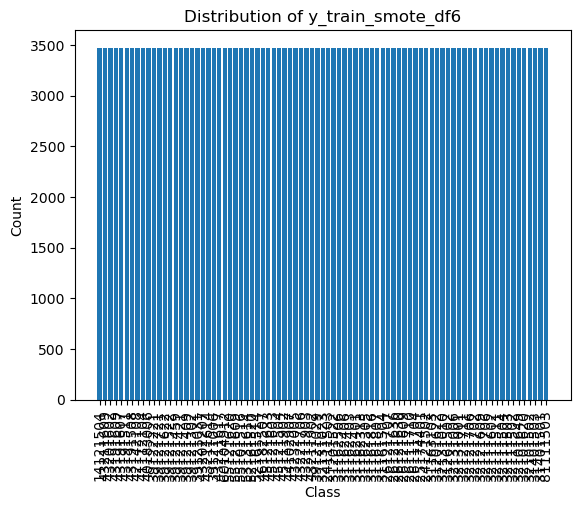

In [328]:
# create a dataframe of the class counts
class_counts = pd.DataFrame(label_encoder_df8.inverse_transform(y_train_smote_df8), columns=['class']).value_counts().reset_index(name='count')

# plot the class counts as a bar chart
plt.bar(class_counts['class'], class_counts['count'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of y_train_smote_df6')
plt.xticks(rotation=90)
plt.show();


In [329]:
 # create a logistic regression object
logreg_final = LogisticRegression(n_jobs=-1, C=100, verbose=3)

In [330]:
# fit the model on the training data
logreg_final.fit(X_train_smote_df8, y_train_smote_df8)

# Save the model to a file
joblib.dump(logreg_final, 'logreg_final.pkl')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.1min finished


LogisticRegression(C=100, n_jobs=-1, verbose=3)

['logreg_final.pkl']

In [331]:
# evaluate the model on the testing data
accuracy_lr_final = logreg_final.score(X_test_df8, y_test_df8)
print('Test accuracy with final hyperparameters:', accuracy_lr_final)


Test accuracy with final hyperparameters: 0.9479596515359927


In [332]:
pred_lr_final = logreg_final.predict(X_test_df8)
pred_lr_final_decoded = label_encoder_df8.inverse_transform(pred_lr_final)
print_validation_report(y_test_df8_decoded, pred_lr_final_decoded)


Classification Report
              precision    recall  f1-score   support

    14121504       0.80      0.80      0.80         5
    24111503       0.95      0.95      0.95        22
    24121502       0.00      0.00      0.00         1
    25174401       1.00      1.00      1.00        22
    26111704       0.83      1.00      0.91         5
    26111710       0.95      0.95      0.95        22
    26121609       0.80      1.00      0.89         4
    26121630       0.71      0.42      0.53        12
    26121636       1.00      0.94      0.97        35
    26121707       0.93      0.86      0.90        74
    31161504       0.99      1.00      0.99        75
    31161807       0.88      0.94      0.91        16
    31161816       1.00      0.87      0.93        15
    31162305       0.80      1.00      0.89        12
    31162313       0.75      0.75      0.75        16
    31162401       1.00      1.00      1.00         2
    31162403       1.00      0.75      0.86         4
    3

In [307]:
df_24121502 = df8[df8['Commodity'] == '24121502']

In [333]:
len(df_24121502)
df_24121502

26

,Product ID,DESCRIPTIONS,UNSPSC CODES,UNSPSC Code Description,ProductID_Type,TOKENS,Product_Description,Segment,Family,Class,Commodity,Pred_LR_FINAL
679,07168-00,"bag, eyeglass clip",24121502,Packaging pouches or bags,hyphenated,"[bag, eyeglass, clip]","07168-00,bag, eyeglass clip",24,2412,241215,24121502,24121502
7141,1516-06bl000,bubble pe clear bag vvx150/250,24121502,Packaging pouches or bags,hyphenated,"[bubble, pe, clear, bag, vvx]","1516-06bl000,bubble pe clear bag vvx150/250",24,2412,241215,24121502,24121502
7142,1516-06w1000,bubble insulator bag szabla,24121502,Packaging pouches or bags,hyphenated,"[bubble, insulator, bag, szabla]","1516-06w1000,bubble insulator bag szabla",24,2412,241215,24121502,24121502
9643,1712-06856-001,"bag,bubble,55"" x 65""",24121502,Packaging pouches or bags,hyphenated,"[bag, bubble]","1712-06856-001,bag,bubble,55"" x 65""",24,2412,241215,24121502,24121502
9644,1712-06856-002,"bag,bubble,9"" x 16""",24121502,Packaging pouches or bags,hyphenated,"[bag, bubble]","1712-06856-002,bag,bubble,9"" x 16""",24,2412,241215,24121502,24121502
9645,1712-06856-003,"bag,bubble,3"" x 5""",24121502,Packaging pouches or bags,hyphenated,"[bag, bubble]","1712-06856-003,bag,bubble,3"" x 5""",24,2412,241215,24121502,24121502
9688,1712-44344-001,"bag,bubble,250x320mm",24121502,Packaging pouches or bags,hyphenated,"[bag, bubble]","1712-44344-001,bag,bubble,250x320mm",24,2412,241215,24121502,24121502
9692,1712-48823-002,"bag,bubble,210x350mm",24121502,Packaging pouches or bags,hyphenated,"[bag, bubble]","1712-48823-002,bag,bubble,210x350mm",24,2412,241215,24121502,24121502
9699,1712-69035-001,"bag,bubble,open end,10""x15""",24121502,Packaging pouches or bags,hyphenated,"[bag, bubble, open, end, ""x]","1712-69035-001,bag,bubble,open end,10""x15""",24,2412,241215,24121502,24121502
10052,17584-11,"bag, poly 10x12",24121502,Packaging pouches or bags,hyphenated,"[bag, poly]","17584-11,bag, poly 10x12",24,2412,241215,24121502,24121502


In [334]:
def predict_unspsc_code_lr(product_description):
    # Vectorize the product_description using the TF-IDF vectorizer
    vectorized_tokens = tfidf_vectors_df8.transform([product_description])
    
    # Make predictions using the trained model
    predictions = logreg_final.predict(vectorized_tokens)
    
    # Convert the predictions from one-hot encoded format to class labels
    predicted_labels = label_encoder_df8.inverse_transform(predictions)
    
    return predicted_labels[0]

def predict_unspsc_code_lr_pd(product_id, description):
    product_description = ','.join([product_id, description])

    return predict_unspsc_code_lr(product_description)

In [335]:
df_24121502['Pred_LR_FINAL'] = df_24121502['Product_Description'].apply(predict_unspsc_code_lr)

In [336]:
df_24121502

,Product ID,DESCRIPTIONS,UNSPSC CODES,UNSPSC Code Description,ProductID_Type,TOKENS,Product_Description,Segment,Family,Class,Commodity,Pred_LR_FINAL
679,07168-00,"bag, eyeglass clip",24121502,Packaging pouches or bags,hyphenated,"[bag, eyeglass, clip]","07168-00,bag, eyeglass clip",24,2412,241215,24121502,24121502
7141,1516-06bl000,bubble pe clear bag vvx150/250,24121502,Packaging pouches or bags,hyphenated,"[bubble, pe, clear, bag, vvx]","1516-06bl000,bubble pe clear bag vvx150/250",24,2412,241215,24121502,24121502
7142,1516-06w1000,bubble insulator bag szabla,24121502,Packaging pouches or bags,hyphenated,"[bubble, insulator, bag, szabla]","1516-06w1000,bubble insulator bag szabla",24,2412,241215,24121502,24121502
9643,1712-06856-001,"bag,bubble,55"" x 65""",24121502,Packaging pouches or bags,hyphenated,"[bag, bubble]","1712-06856-001,bag,bubble,55"" x 65""",24,2412,241215,24121502,24121502
9644,1712-06856-002,"bag,bubble,9"" x 16""",24121502,Packaging pouches or bags,hyphenated,"[bag, bubble]","1712-06856-002,bag,bubble,9"" x 16""",24,2412,241215,24121502,24121502
9645,1712-06856-003,"bag,bubble,3"" x 5""",24121502,Packaging pouches or bags,hyphenated,"[bag, bubble]","1712-06856-003,bag,bubble,3"" x 5""",24,2412,241215,24121502,24121502
9688,1712-44344-001,"bag,bubble,250x320mm",24121502,Packaging pouches or bags,hyphenated,"[bag, bubble]","1712-44344-001,bag,bubble,250x320mm",24,2412,241215,24121502,24121502
9692,1712-48823-002,"bag,bubble,210x350mm",24121502,Packaging pouches or bags,hyphenated,"[bag, bubble]","1712-48823-002,bag,bubble,210x350mm",24,2412,241215,24121502,24121502
9699,1712-69035-001,"bag,bubble,open end,10""x15""",24121502,Packaging pouches or bags,hyphenated,"[bag, bubble, open, end, ""x]","1712-69035-001,bag,bubble,open end,10""x15""",24,2412,241215,24121502,24121502
10052,17584-11,"bag, poly 10x12",24121502,Packaging pouches or bags,hyphenated,"[bag, poly]","17584-11,bag, poly 10x12",24,2412,241215,24121502,24121502
